<a href="https://colab.research.google.com/github/YiJun10565/social-network/blob/main/Social_Networking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import & Class define

In [ ]:
!pip install igraph jgraph python-igraph

     |████████████████████████████████| 122kB 8.9MB/s 
     |████████████████████████████████| 122kB 36.9MB/s 
     |████████████████████████████████| 3.2MB 38.1MB/s 


In [ ]:
import numpy as np
import random
import igraph
import time

# Simulation

### Class


In [ ]:
class Game:
  def __init__(self, n_nodes, n_edges, u, w, cooperateProb, alpha, printFlag=False):
    self.graph = igraph.Graph.Erdos_Renyi(n=n_nodes, m=n_edges)
    self.n_nodes = n_nodes
    self.n_edges = n_edges
    self.u = u
    self.w = w
    self.cooperateProb = cooperateProb
    self.cooperateState = [True if random.random() > cooperateProb  else False for _ in range(n_nodes)]
    self.alpha = alpha
    self.payoffMatrix = [[1, 0], [1+u, u]]
    self.printFlag = printFlag

    self.CC = igraph.Graph.Erdos_Renyi(n=n_nodes, m=0)
    self.CD = igraph.Graph.Erdos_Renyi(n=n_nodes, m=0)
    self.DD = igraph.Graph.Erdos_Renyi(n=n_nodes, m=0)
    self.SeperateEdges()
    #print(len(self.CC.get_edgelist()), len(self.CD.get_edgelist()), len(self.DD.get_edgelist()), len(self.CC.get_edgelist())+len(self.CD.get_edgelist())+len(self.DD.get_edgelist()))
    self.time = 0
    #if self.printFlag:
    #  print(self.cooperateState)
    

  def Run(self):
    while len(self.CD.get_edgelist()) > 0:
      if self.printFlag:
        self.PrintStates()
      self.RunOneTime()
      self.time += 1
      '''
      if self.time % 100 == 0:
        print(self.time, sum(self.cooperateState))
    print("num of Cooperators: {}| num of Betrayers {}| num of CC edges: {}| num of DD edges: {}".format(
        sum(self.cooperateState), 
        self.n_nodes - sum(self.cooperateState),
        len(self.CC.get_edgelist()), 
        len(self.DD.get_edgelist())
        ))
      '''
    if self.printFlag:
      self.PrintStates()
    return self.time

  def RunOneTime(self):
    chosenEdge = random.sample(self.CD.get_edgelist(), 1)[0]
    if self.printFlag:
      print(chosenEdge, self.cooperateState[chosenEdge[0]], self.cooperateState[chosenEdge[1]],":", end=' ')
    
    assert self.cooperateState[chosenEdge[0]] != self.cooperateState[chosenEdge[1]]
    X = random.random()
    if X > self.w: # E_ij is rewired (The C node find another player)
      if self.printFlag:
        print("random>self.w({:.2f}:{}) ->Rewire:".format(X, self.w), end=' ')
      node_idx = chosenEdge[0] if self.cooperateState[chosenEdge[0]] else chosenEdge[1]
      connectedNodes = [node_idx]
      for edge in self.graph.get_edgelist():
        if edge[0] == node_idx:
          connectedNodes.append(edge[1])
        if edge[1] == node_idx:
          connectedNodes.append(edge[0])
      notConnectedNode = [i for i in range(self.n_nodes) if i not in connectedNodes]
      
      if len(notConnectedNode) > 0:
        new_node_idx = random.sample(notConnectedNode, 1)[0]
        # remove old edge
        self.graph.delete_edges([chosenEdge])
        self.CD.delete_edges([chosenEdge])
        # add new edge
        new_edge = (node_idx, new_node_idx)
        self.graph.add_edge(*new_edge)
        if self.cooperateState[new_node_idx]:
          self.CC.add_edge(*new_edge)
          if self.printFlag:
            print("CD->CC:", new_edge)
        else:
          self.CD.add_edge(*new_edge)
          if self.printFlag:
            print("CD->CD", new_edge)

    else: # Copy strategy with fermi_function
      if self.printFlag:
        print("random<self.w({:.2f}:{}) Copy strategy:".format(X, self.w), end=" ")

      if random.random() <= self.FermiFunction(chosenEdge[0], chosenEdge[1]):
        src_node = chosenEdge[0]
        tgt_node = chosenEdge[1]
      else :
        src_node = chosenEdge[1]
        tgt_node = chosenEdge[0]

      if self.printFlag:
        if self.cooperateState[src_node]:
          print(src_node,"C->D", end=" ")
        else:
          print(src_node,"D->C", end=" ")
      CC2CD, CD2CC, CD2DD, DD2CD = [], [], [], []
      # Update edges of source node
      if self.cooperateState[src_node]:
        for edge in self.CC.get_edgelist():
          if src_node in edge:
              CC2CD.append(edge)
              if self.printFlag:
                print(edge, end=' ')
              self.CC.delete_edges([edge])
              #self.CD.add_edge(*edge)
        
        for edge in self.CD.get_edgelist():
          if src_node in edge:
              CD2DD.append(edge)
              if self.printFlag:
                print(edge, end=' ')
              self.CD.delete_edges([edge])
              #self.DD.add_edge(*edge)
        for edge in CC2CD:
          self.CD.add_edge(*edge)
        for edge in CD2DD:
          self.DD.add_edge(*edge)
      else:
        for edge in self.CD.get_edgelist():
          if src_node in edge:
              CD2CC.append(edge)
              if self.printFlag:            
                print(edge, end=' ')
              self.CD.delete_edges([edge])
              #self.CC.add_edge(*edge)
        
        for edge in self.DD.get_edgelist():
          if src_node in edge:
              DD2CD.append(edge)
              if self.printFlag:
                print(edge, end=' ')
              self.DD.delete_edges([edge])
              #self.CD.add_edge(*edge)
        for edge in CD2CC:
          self.CC.add_edge(*edge)
        for edge in DD2CD:
          self.CD.add_edge(*edge)
      # Update source node
      if self.printFlag:
        print(self.cooperateState[src_node], "->" , self.cooperateState[tgt_node])
      self.cooperateState[src_node] = self.cooperateState[tgt_node]
      if self.printFlag:
        print("CC->CD:{}, CD->CC:{}, CD->DD:{}, DD->CD:{}".format(CC2CD, CD2CC, CD2DD, DD2CD))
      time.sleep(0.001)

  def FermiFunction(self, node_idx1, node_idx2):
    payoff1 = self.CalculatePayoff(node_idx1)
    payoff2 = self.CalculatePayoff(node_idx2)
    if self.printFlag:
      print("node:", node_idx1, "payoff1:", payoff1, "| node:", node_idx2, "payoff2:", payoff2, end=" ")
    return 1/(1+np.exp(alpha*( payoff1 - payoff2 )))

  def CalculatePayoff(self, node_idx):
    payOff = 0
    if self.cooperateState[node_idx]:
      for edge in self.CC.get_edgelist():
        if node_idx in edge:
          payOff += 1
      #for edge in self.CD.get_edgelist():
      #  if node_idx in edge:
      #    payOff += 0
    else:
      for edge in self.CD.get_edgelist():
        if node_idx in edge:
          payOff += 1+self.u
      for edge in self.DD.get_edgelist():
        if node_idx in edge:
          payOff += self.u
    return payOff

  def SeperateEdges(self):
    self.CC.delete_edges()
    self.CD.delete_edges()
    self.DD.delete_edges()

    for edge in self.graph.get_edgelist():
      if self.isCC(*edge):
        self.CC.add_edge(*edge)
      elif self.isDD(*edge):
        self.DD.add_edge(*edge)
      elif self.isCD(*edge):
        self.CD.add_edge(*edge)
      else:
        raise ValueError(edge, self.cooperateState[edge[0]], self.cooperateState[edge[1]])

    if self.printFlag:
      print('CC:', len(self.CC.get_edgelist()))
      print('CD:', len(self.CD.get_edgelist()))
      print('DD:', len(self.DD.get_edgelist()))

    return

  def isCC(self, a, b):
    return self.cooperateState[a] and self.cooperateState[b]
  def isDD(self, a, b):
    return not self.cooperateState[a] and not self.cooperateState[b]
  def isCD(self, a, b):
    return (not self.cooperateState[a] and self.cooperateState[b]) or (self.cooperateState[a] and not self.cooperateState[b])
  

  def PrintStates(self):
    print("{:6d} time, C-Nodes:{}, D-Nodes:{}, C-C edges:{:5d}, C-D edges:{:5d}, D-D edges:{:5d}".format(self.time, sum(self.cooperateState), self.n_nodes-sum(self.cooperateState), len(self.CC.get_edgelist()), len(self.CD.get_edgelist()), len(self.DD.get_edgelist())))

## Simulations

### given 4 w with different u

In [ ]:
import tqdm
import tqdm.notebook as tq

if __name__ == "__main__":
  n_nodes = 1000
  n_edges = 5000
  u_list = [i/100 for i in range(0, 101, 2)]
  w_list = [0, 0.05, 0.1, 0.5]
  simulations_w = {}
  num_epoch = 10
  #u = 0.5 # utility
  #w = 0.1 # strategy updating  probability
  cooperateProb = 0.5
  alpha = 30
  for i, w in enumerate(w_list):
    print('========== w=', w, ' ==========')
    simulations_w[str(w)] = []
    for u in u_list:
      print('---------- u=', u, ' ----------')
      start = time.time()
      cooperator_count = 0
      total_count = 0
      pbar = tq.tqdm(range(num_epoch))
      for _ in pbar:
        game = Game(n_nodes, n_edges, u, w, cooperateProb, alpha, False)
        game.Run()
        cooperator_count += sum(game.cooperateState)
        total_count += n_nodes
        pbar.set_description('w = '+str(w)+' | u = '+str(u)+' | % of cooperators = '+str(round(cooperator_count/total_count, 3)))
        pbar.refresh()
        del game
      pbar.close()
      simulations_w[str(w)].append(cooperator_count/total_count)
      #print(cc_count, dd_count, cc_count / (cc_count + dd_count), time.time()-start)
    

========== w= 0  ==========
---------- u= 0.0  ----------



---------- u= 0.02  ----------



---------- u= 0.04  ----------



---------- u= 0.06  ----------



---------- u= 0.08  ----------



---------- u= 0.1  ----------



---------- u= 0.12  ----------



---------- u= 0.14  ----------



---------- u= 0.16  ----------



---------- u= 0.18  ----------



---------- u= 0.2  ----------



---------- u= 0.22  ----------



---------- u= 0.24  ----------



---------- u= 0.26  ----------



---------- u= 0.28  ----------



---------- u= 0.3  ----------



---------- u= 0.32  ----------



---------- u= 0.34  ----------



---------- u= 0.36  ----------



---------- u= 0.38  ----------



---------- u= 0.4  ----------



---------- u= 0.42  ----------



---------- u= 0.44  ----------



---------- u= 0.46  ----------



---------- u= 0.48  ----------



---------- u= 0.5  ----------



---------- u= 0.52  ----------



---------- u= 0.54  ----------



---------- u= 0.56  ----------



---------- u= 0.58  ----------



---------- u= 0.6  ----------



---------- u= 0.62  ----------



---------- u= 0.64  ----------



---------- u= 0.66  ----------



---------- u= 0.68  ----------



---------- u= 0.7  ----------



---------- u= 0.72  ----------



---------- u= 0.74  ----------



---------- u= 0.76  ----------



---------- u= 0.78  ----------



---------- u= 0.8  ----------



---------- u= 0.82  ----------



---------- u= 0.84  ----------



---------- u= 0.86  ----------



---------- u= 0.88  ----------



---------- u= 0.9  ----------



---------- u= 0.92  ----------



---------- u= 0.94  ----------



---------- u= 0.96  ----------



---------- u= 0.98  ----------



---------- u= 1.0  ----------



========== w= 0.05  ==========
---------- u= 0.0  ----------



---------- u= 0.02  ----------



---------- u= 0.04  ----------



---------- u= 0.06  ----------



---------- u= 0.08  ----------



---------- u= 0.1  ----------



---------- u= 0.12  ----------



---------- u= 0.14  ----------



---------- u= 0.16  ----------



---------- u= 0.18  ----------



---------- u= 0.2  ----------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:151: RuntimeWarning: overflow encountered in exp



---------- u= 0.22  ----------



---------- u= 0.24  ----------



---------- u= 0.26  ----------



---------- u= 0.28  ----------



---------- u= 0.3  ----------



---------- u= 0.32  ----------



---------- u= 0.34  ----------



---------- u= 0.36  ----------



---------- u= 0.38  ----------



---------- u= 0.4  ----------



---------- u= 0.42  ----------



---------- u= 0.44  ----------



---------- u= 0.46  ----------



---------- u= 0.48  ----------



---------- u= 0.5  ----------



---------- u= 0.52  ----------



---------- u= 0.54  ----------



---------- u= 0.56  ----------



---------- u= 0.58  ----------



---------- u= 0.6  ----------



---------- u= 0.62  ----------



---------- u= 0.64  ----------



---------- u= 0.66  ----------



---------- u= 0.68  ----------



---------- u= 0.7  ----------



---------- u= 0.72  ----------



---------- u= 0.74  ----------



---------- u= 0.76  ----------



---------- u= 0.78  ----------



---------- u= 0.8  ----------



---------- u= 0.82  ----------



---------- u= 0.84  ----------



---------- u= 0.86  ----------



---------- u= 0.88  ----------



---------- u= 0.9  ----------



---------- u= 0.92  ----------



---------- u= 0.94  ----------



---------- u= 0.96  ----------



---------- u= 0.98  ----------



---------- u= 1.0  ----------



========== w= 0.1  ==========
---------- u= 0.0  ----------



---------- u= 0.02  ----------



---------- u= 0.04  ----------



---------- u= 0.06  ----------



---------- u= 0.08  ----------



---------- u= 0.1  ----------



---------- u= 0.12  ----------



---------- u= 0.14  ----------



---------- u= 0.16  ----------



---------- u= 0.18  ----------



---------- u= 0.2  ----------



---------- u= 0.22  ----------


NameError: ignored

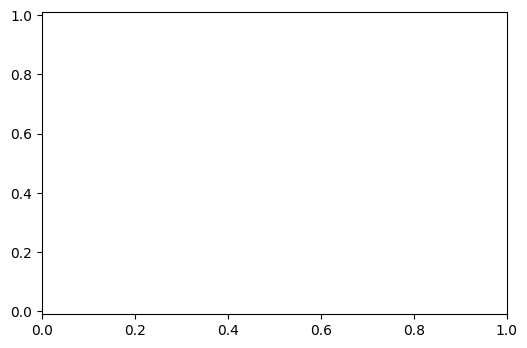

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4),dpi=100,linewidth = 2)
plt.xlim(-0.001, 1)
plt.ylim(-0.01, 1.01)

u_list = [i/100 for i in range(0, 101, 5)]
plt.plot(u_list, simulations_w['0'] , 's-', color = 'k', label="w = 0", )
plt.plot(u_list, simulations_w['0.05'], 'o-', color = 'r', label="w = 0.05", )
plt.plot(u_list, simulations_w['0.1'], '^-', color = 'g', label="w = 0.1", )
plt.plot(u_list, simulations_w['0.5'], 'v-', color = 'b', label="w = 0.5", )

#plt.plot(month,stock_foxconnn,'o-',color = 'g', label="FOXCONN")

plt.title("Simulation Chart")
plt.xlabel("Cost-to-benefit ratio, u")
plt.ylabel("Fraction of cooperates")

plt.legend(loc = "best", fontsize=10)

plt.show()

### Given 4 u with different w

In [ ]:
import tqdm
import tqdm.notebook as tq

if __name__ == "__main__":
  n_nodes = 1000
  n_edges = 5000
  u_list = [0.2]   # utility
  w_list = [i/100 for i in range(0, 101, 2)]  # strategy updating  probability
  simulations_u = {}
  num_epoch = 30
  cooperateProb = 0.5
  alpha = 30
  for i, u in enumerate(u_list):
    print('========== u=', u, ' ==========')
    simulations_u[str(u)] = []
    for w in w_list:
      print('---------- w=', w, ' ----------')
      start = time.time()
      cooperator_count = 0
      total_count = 0
      pbar = tq.tqdm(range(num_epoch))
      for _ in pbar:
        game = Game(n_nodes, n_edges, u, w, cooperateProb, alpha, False)
        game.Run()
        cooperator_count += sum(game.cooperateState)
        total_count += n_nodes
        pbar.set_description('w = '+str(w)+' | u = '+str(u)+' | % of cooperators = '+str(round(cooperator_count/total_count, 3)))
        pbar.refresh()
        del game
      pbar.close()
      simulations_u[str(u)].append(cooperator_count/total_count)
      #print(cc_count, dd_count, cc_count / (cc_count + dd_count), time.time()-start)
    

========== u= 0.2  ==========
---------- w= 0.2  ----------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:151: RuntimeWarning: overflow encountered in exp



---------- w= 0.22  ----------



---------- w= 0.24  ----------



---------- w= 0.26  ----------



---------- w= 0.28  ----------



---------- w= 0.3  ----------



---------- w= 0.32  ----------



---------- w= 0.34  ----------



---------- w= 0.36  ----------



---------- w= 0.38  ----------



---------- w= 0.4  ----------



---------- w= 0.42  ----------



---------- w= 0.44  ----------



---------- w= 0.46  ----------


KeyboardInterrupt: ignored

In [ ]:
import tqdm
import tqdm.notebook as tq

if __name__ == "__main__":
  n_nodes = 200
  n_edges = 1000
  u_list = [0.01]   # utility
  w_list = [0.9]  # strategy updating  probability
  simulations_u = {}
  num_epoch = 10
  cooperateProb = 0.5
  alpha = 30
  for i, u in enumerate(u_list):
    print('========== u=', u, ' ==========')
    #simulations_u[str(u)] = []
    for w in w_list:
      print('---------- w=', w, ' ----------')
      start = time.time()
      cooperator_count = 0
      total_count = 0
      pbar = tq.tqdm(range(num_epoch))
      for _ in pbar:
        game = Game(n_nodes, n_edges, u, w, cooperateProb, alpha, False)
        game.Run()
        cooperator_count += sum(game.cooperateState)
        total_count += n_nodes
        pbar.set_description('w = '+str(w)+' | u = '+str(u)+' | % of cooperators = '+str(round(cooperator_count/total_count, 3)))
        pbar.refresh()
        del game
      pbar.close()
      #simulations_u[str(u)].append(cooperator_count/total_count)
      #print(cc_count, dd_count, cc_count / (cc_count + dd_count), time.time()-start)
    

========== u= 0.01  ==========
---------- w= 0.9  ----------


In [ ]:
print(simulations_u)

{}


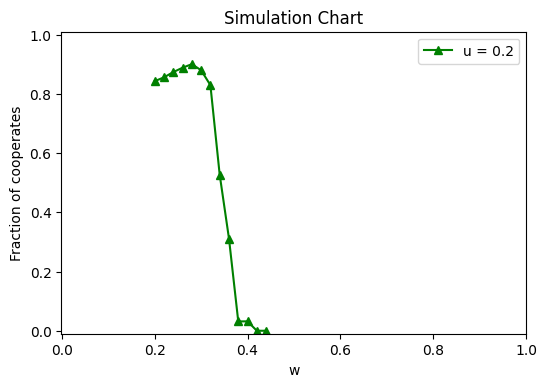

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4),dpi=100,linewidth = 2)
plt.xlim(-0.001, 1)
plt.ylim(-0.01, 1.01)

#plt.plot(w_list, simulations_u['0'] , 's-', color = 'k', label="u = 0", )
#plt.plot(w_list, simulations_u['0.01'], 'o-', color = 'r', label="u = 0.01", )
plt.plot(w_list[:13], simulations_u['0.2'], '^-', color = 'g', label="u = 0.2", )
#plt.plot(w_list, simulations_u['0.8'], 'v-', color = 'b', label="u = 0.8", )

#plt.plot(month,stock_foxconnn,'o-',color = 'g', label="FOXCONN")

plt.title("Simulation Chart")
plt.xlabel("w")
plt.ylabel("Fraction of cooperates")

plt.legend(loc = "best", fontsize=10)

plt.show()

### Custom try

In [ ]:
tq.tqdm._instances.clear()
tq.tqdm_notebook._instances.clear()

In [ ]:
import tqdm
import tqdm.notebook as tq

if __name__ == "__main__":
  n_nodes = 1000
  n_edges = 5000
  u_list = [0.2]   # utility
  w_list = [0.4]  # strategy updating  probability
  #simulations_u = {}
  num_epoch = 1
  cooperateProb = 0.5
  alpha = 30
  for i, u in enumerate(u_list):
    print('========== u=', u, ' ==========')
    #simulations_u[str(u)] = []
    for w in w_list:
      print('---------- w=', w, ' ----------')
      start = time.time()
      cooperator_count = 0
      total_count = 0
      pbar = tq.tqdm(range(num_epoch))
      for _ in pbar:
        game = Game(n_nodes, n_edges, u, w, cooperateProb, alpha, False)
        game.Run()
        cooperator_count += sum(game.cooperateState)
        total_count += n_nodes
        pbar.set_description('w = '+str(w)+' | u = '+str(u)+' | % of C:'+str(round(cooperator_count/total_count, 3)))
        pbar.refresh()
        del game
      pbar.close()
      #simulations_u[str(u)].append(cooperator_count/total_count)
      print(cooperator_count, total_count, cooperator_count / total_count, time.time()-start)
    

========== u= 0.2  ==========
---------- w= 0.4  ----------


100 438
200 415
300 391
400 364
500 347
600 326
700 299
800 286
900 273
1000 254
1100 241
1200 225
1300 209
1400 190
1500 162
1600 147
1700 134
1800 118
1900 105
2000 89
2100 73
2200 53
num of Cooperators: 48| num of Betrayers 952| num of CC edges: 53| num of DD edges: 4947

48 1000 0.048 9.49553894996643
